In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [9]:
data_path = "/kaggle/input/animals10/raw-img"

# Load and split the dataset (80% train, 20% val)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


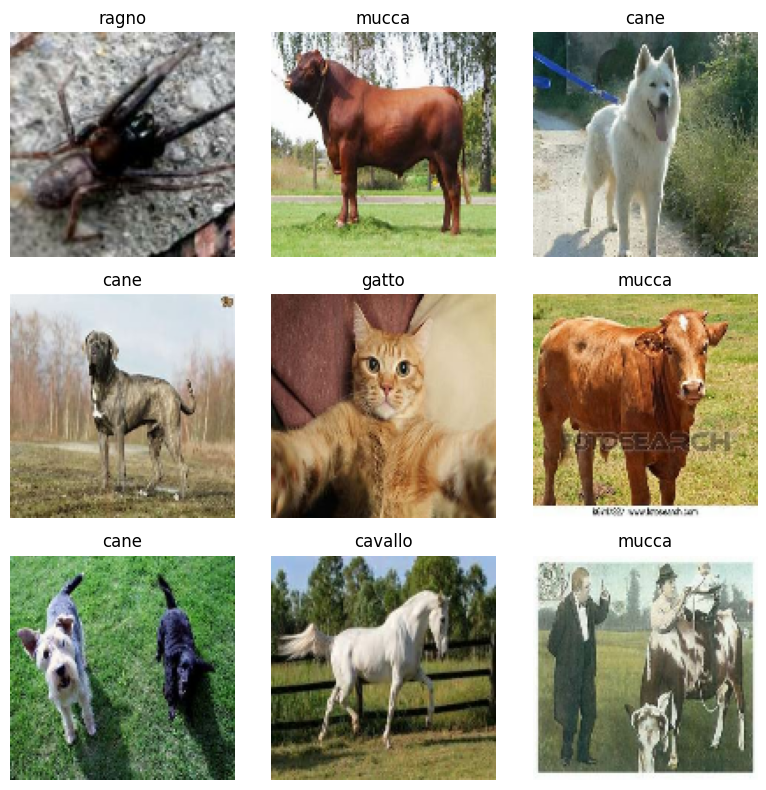

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.tight_layout()
plt.show()


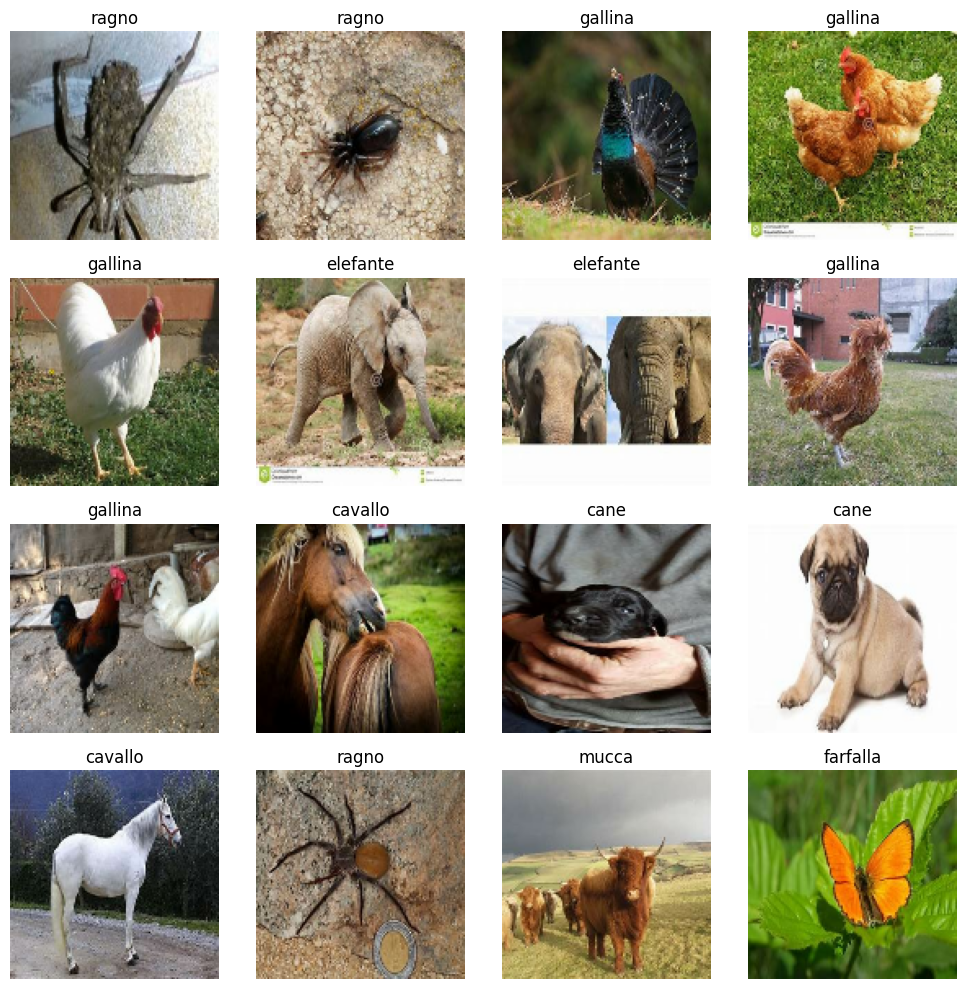

In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf

sample_ds = train_ds.unbatch().shuffle(1000).batch(16).take(1)

plt.figure(figsize=(10, 10))
for images, labels in sample_ds:
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [11]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.90:
            self.model.stop_training = True
            print("\nReached 90% validation accuracy. Stopping training!")


In [12]:
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [13]:
model = create_cnn_model()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[EarlyStoppingCallback()]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


655/655 ━━━━━━━━━━━━━━━━━━━━ 645s 981ms/step - accuracy: 0.3064 - loss: 1.9653 - val_accuracy: 0.5511 - val_loss: 1.3522
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 680s 978ms/step - accuracy: 0.5648 - loss: 1.2776 - val_accuracy: 0.6229 - val_loss: 1.1453
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 722s 1s/step - accuracy: 0.6748 - loss: 0.9620 - val_accuracy: 0.6279 - val_loss: 1.1575
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 672s 1s/step - accuracy: 0.7571 - loss: 0.7200 - val_accuracy: 0.6308 - val_loss: 1.2388
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 670s 1s/step - accuracy: 0.8373 - loss: 0.4903 - val_accuracy: 0.6432 - val_loss: 1.3912
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 645s 967ms/step - accuracy: 0.8863 - loss: 0.3272 - val_accuracy: 0.6426 - val_loss: 1.5856
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 673s 1s/step - accuracy: 0.9257 - loss: 0.2218 - val_accuracy: 0.6415 - val_loss: 1.8479
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 633s 965ms/step - accuracy: 0.9453 - loss: 0.1647 - val_acc

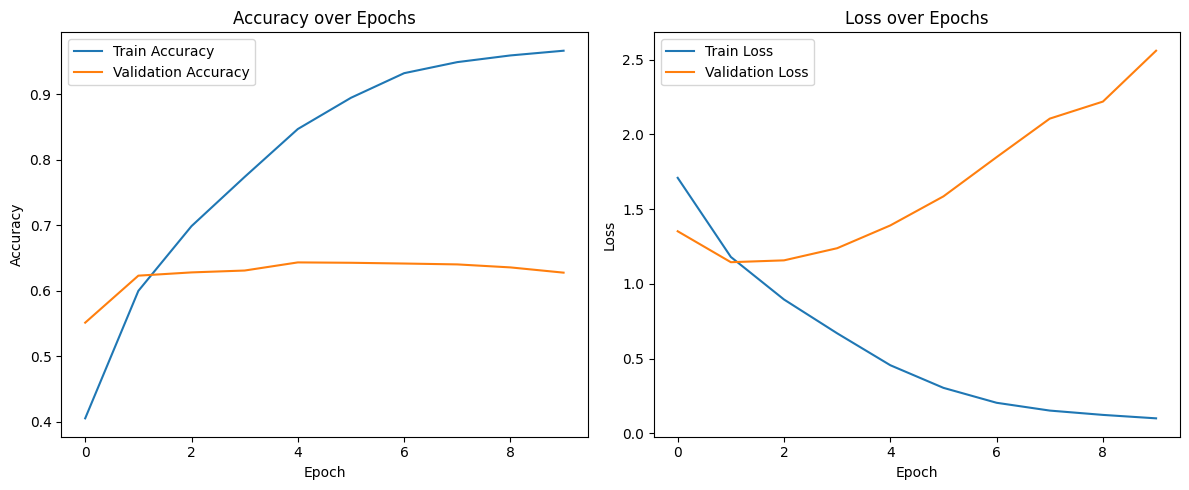

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
# Map Italian class names to English
translation = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Prediction for: dog.jpg
dog: 71.72%
cow: 26.89%
elephant: 1.07%


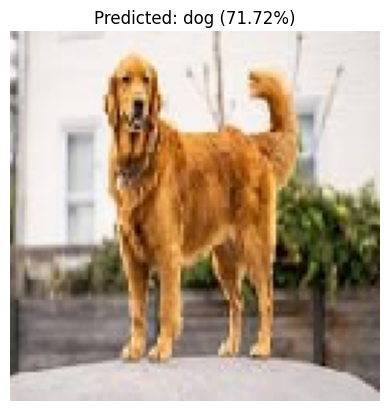

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_image(img_path, model, class_names, target_size=(128, 128), top_k=3):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_arr = tf.keras.utils.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    probs = model.predict(img_arr)[0]
    top_indices = probs.argsort()[-top_k:][::-1]

    print(f"\nPrediction for: {img_path}")
    for i in top_indices:
        class_it = class_names[i]
        class_en = translation[class_it]
        print(f"{class_en}: {probs[i]*100:.2f}%")

    plt.imshow(tf.keras.utils.array_to_img(img_arr[0]))
    plt.axis('off')
    plt.title(f"Predicted: {translation[class_names[top_indices[0]]]} ({probs[top_indices[0]]*100:.2f}%)")
    plt.show()
# ---- use it ----
test_image_path = "dog.jpg"   # change to your image path
predict_image(test_image_path, model, class_names, target_size=(128, 128), top_k=3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Prediction for: sheep.jpg
sheep: 99.99%
cow: 0.01%
dog: 0.00%


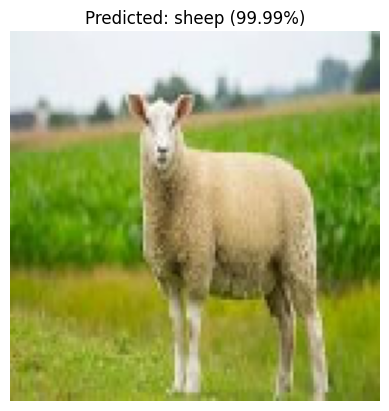

In [30]:
# ---- use it ----
test_image_path = "sheep.jpg"   # change to your image path
predict_image(test_image_path, model, class_names, target_size=(128, 128), top_k=3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Prediction for: sq.jpg
squirrel: 100.00%
butterfly: 0.00%
spider: 0.00%


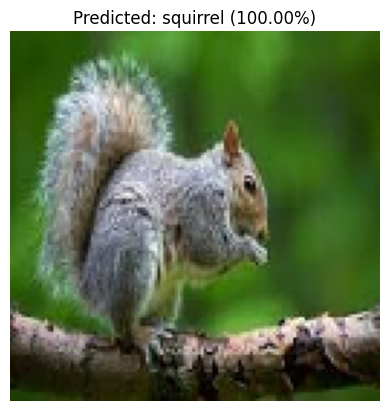

In [31]:
# ---- use it ----
test_image_path = "sq.jpg"   # change to your image path
predict_image(test_image_path, model, class_names, target_size=(128, 128), top_k=3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Prediction for: ho.jpg
horse: 67.23%
cow: 32.77%
dog: 0.00%


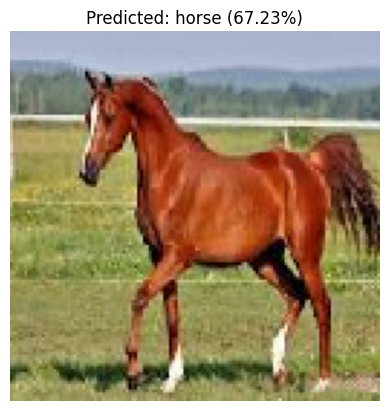

In [32]:
# ---- use it ----
test_image_path = "ho.jpg"   # change to your image path
predict_image(test_image_path, model, class_names, target_size=(128, 128), top_k=3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Prediction for: sp.jpg
spider: 100.00%
horse: 0.00%
dog: 0.00%


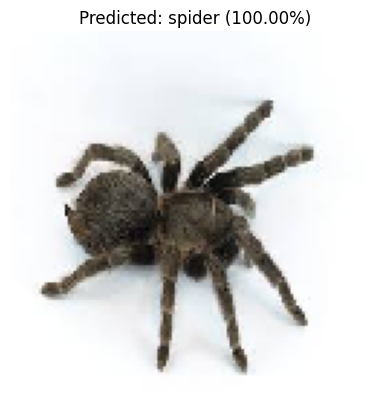

In [33]:
# ---- use it ----
test_image_path = "sp.jpg"   # change to your image path
predict_image(test_image_path, model, class_names, target_size=(128, 128), top_k=3)


In [35]:

val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2%}, Validation Loss: {val_loss:.4f}")


164/164 ━━━━━━━━━━━━━━━━━━━━ 45s 271ms/step - accuracy: 0.6269 - loss: 2.6239
Validation Accuracy: 62.75%, Validation Loss: 2.5597


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

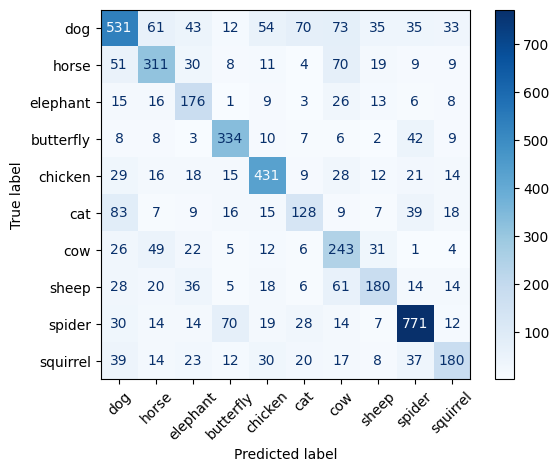

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[translation[c] for c in class_names])
disp.plot(xticks_rotation=45, cmap='Blues')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


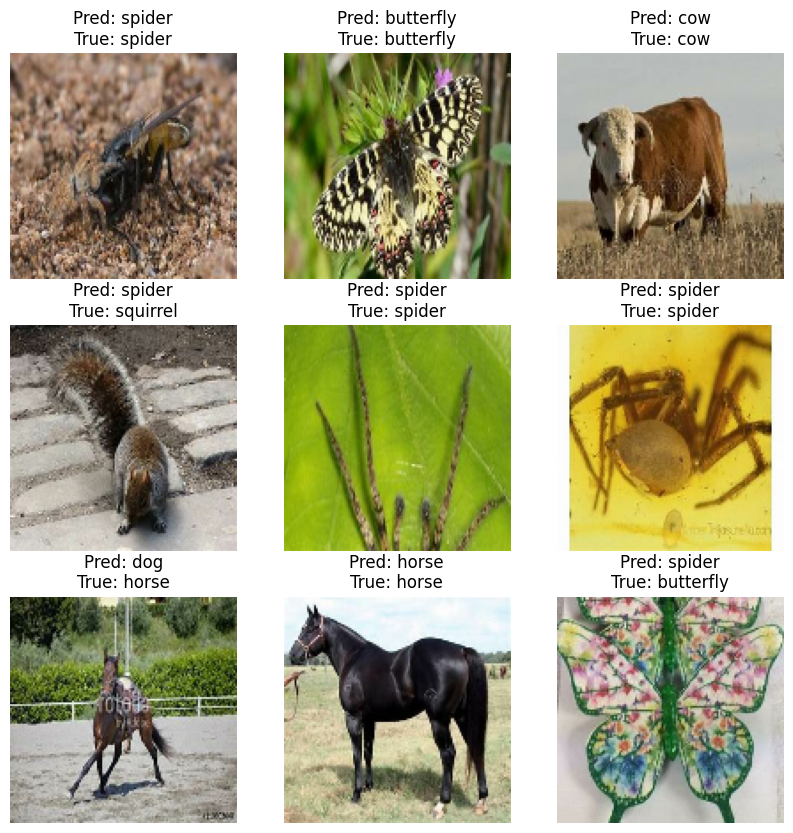

In [37]:
import random

for images, labels in val_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy()
        pred = model.predict(img[np.newaxis, ...])
        pred_class = translation[class_names[np.argmax(pred)]]
        true_class = translation[class_names[labels[i].numpy()]]
        plt.imshow(img)
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis("off")
    plt.show()
